In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline


# unpack files and read in meta learner X data
path = '../ensemble/'
train_files = [file for file in os.listdir(path) if 'train_' in file]
test_files = [file for file in os.listdir(path) if 'test_' in file]
model_files = [file for file in os.listdir(path) if 'models_' in file]


# read in meta learner data
def read_data(files):
    df = pd.DataFrame()
    for i in range(len(files)):
        df = pd.concat([df,pd.read_csv(path + files[i])], axis=1)
    return df

X_train = read_data(train_files)
X_test = read_data(test_files)


# read in the labels and outcomes
train_ids_labs = pd.read_csv('../objects/train_ids_labs.csv')
test_ids_labs = pd.read_csv('../objects/test_ids_labs.csv')
id_train, id_test = train_ids_labs['PATIENT_ID'], test_ids_labs['PATIENT_ID']
y_train, y_test = train_ids_labs['dep'], test_ids_labs['dep']

In [2]:
X_train.head()

,entropy,iqrs,maxs,means,medians,mins,ranges,rmssds,sds
0,0.055043,0.104521,0.028034,0.023958,0.020783,0.060612,0.082454,0.076952,0.102119
1,0.052605,0.072661,0.042279,0.032428,0.046397,0.050354,0.039848,0.059998,0.100598
2,0.100758,0.080296,0.021742,0.099563,0.062657,0.023645,0.074340,0.072682,0.072833
3,0.129793,0.121921,0.071868,0.065295,0.054835,0.074057,0.107329,0.174419,0.059332
4,0.062065,0.092424,0.049673,0.029979,0.019406,0.033278,0.090908,0.102249,0.069183


In [3]:
X_train.drop(['iqrs', 'entropy', 'maxs', 'mins', 'ranges'], axis=1, inplace=True)
X_test.drop(['iqrs', 'entropy', 'maxs', 'mins', 'ranges'], axis=1, inplace=True)

X_train.head()


,means,medians,rmssds,sds
0,0.023958,0.020783,0.076952,0.102119
1,0.032428,0.046397,0.059998,0.100598
2,0.099563,0.062657,0.072682,0.072833
3,0.065295,0.054835,0.174419,0.059332
4,0.029979,0.019406,0.102249,0.069183


In [4]:
# view the distributions of features to ensure they are on the same scale
print(pd.DataFrame([X_train.mean(axis=0), X_train.std(axis=0)], index=['mean', 'std']))

# train the meta learner
model = Pipeline([
    ('scaler', MinMaxScaler()),  # to get things on a probability distribution
    ('logreg', LogisticRegression(random_state=123))  # Logistic Regression model
])

model.fit(X_train, y_train)
model.named_steps['logreg'].coef_

         means   medians    rmssds       sds
mean  0.135654  0.136141  0.135603  0.137681
std   0.160533  0.160835  0.088899  0.093038


array([[2.86858843, 1.94892595, 1.59883127, 0.60214135]])

In [5]:
# extract the probs and actuals
probs = model.predict_proba(X_test)[:,1]
actuals = y_test


# write to folder
out = pd.DataFrame({'id': id_test, 'probs':probs, 'actuals':actuals})
out.head()
out.to_csv('../results/preds.csv', index=False)


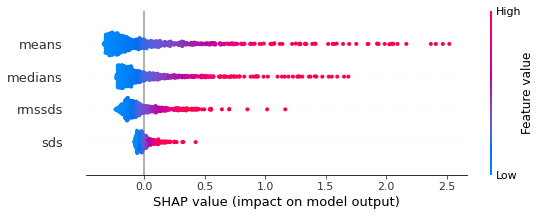

In [6]:
# # 1. Extract the logistic regression model from the pipeline
# import shap
# logreg = model.named_steps['logreg']
# scaler = model.named_steps['scaler']

# # 2. Scale the data manually to ensure SHAP values are calculated correctly
# X_test_scaled = scaler.transform(X_test)

# # 3. Initialize SHAP Explainer
# explainer = shap.Explainer(logreg, X_test_scaled)

# # 4. Calculate SHAP values
# shap_values = explainer(X_test_scaled)

# # Visualize SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)